# CONTENT-BASED sistem za preporuku filmova koristeći TF-IDF

Cilj nam je izgradnja sistema za preporuku filmova koji je zasnovan na sadržaju (*content-based*), koristeći TF-IDF (*term frequency-inverse document frequency*). Zatim implementiramo funkciju koja koja za datog korisnika i film predviđa ocenu koju bi taj korisnik dao tom filmu.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from ast import literal_eval
from scipy import sparse as sps
from sklearn.metrics import mean_squared_error
import math
import warnings; warnings.simplefilter('ignore')

## Sistem za preporuku zasnovan na opisu filma
Pravimo sistem za preporuku koristeći opis filma (atribut *overview*) i etikete (atribut *tagline*). Najpre učitajmo i pripremimo neophodne podatke.

In [2]:
movies = pd.read_csv('the-movies-dataset/movies_metadata.csv')
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null float64
runtime                  45203 non-null float64
spoken_languages         45460 non-null object
status                   45379 non-null objec

Zbor računarskih ograničenja, koristićemo podskup skupa svih filmova, koji se sastoji od oko 9,000 filmova, onih za koje postoje informacije u *ratings_small.csv* i *links_small.csv*. Filtriramo *movies*. 

In [4]:
links_small = pd.read_csv('the-movies-dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]
links_small['tmdbId'] = links_small['tmdbId'].astype('int')

Kolona *id* sadrži podatke tipa **object**. Identifikator treba da bude ceo broj. Pokušamo kastovanje. Nailazimo na problem! Neki redovi sadrže loše formatirane identifikatore (nisu numeričke vrednosti), te kastovanje nije moguće. To su redovi 19730, 29503, 35587. Eliminišemo te redove.

In [5]:
#movies['id'] = movies['id'].astype('int') -- error
print(movies[pd.to_numeric(movies['id'], errors='coerce').isnull()])

                                                   adult  \
19730                                 - Written by Ørnås   
29503   Rune Balot goes to a casino connected to the ...   
35587   Avalanche Sharks tells the story of a bikini ...   

      belongs_to_collection                            budget  \
19730              0.065736  /ff9qCepilowshEtG2GYWwzt2bs4.jpg   
29503              1.931659  /zV8bHuSL6WXoD6FWogP9j4x80bL.jpg   
35587              2.185485  /zaSf5OG7V8X8gqFvly88zDdRm46.jpg   

                                                  genres  \
19730  [{'name': 'Carousel Productions', 'id': 11176}...   
29503  [{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...   
35587  [{'name': 'Odyssey Media', 'id': 17161}, {'nam...   

                                                homepage          id imdb_id  \
19730  [{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...  1997-08-20       0   
29503  [{'iso_3166_1': 'US', 'name': 'United States o...  2012-09-29       0   
35587           [

In [6]:
movies = movies.drop([19730, 29503, 35587])

In [7]:
movies['id'] = movies['id'].astype('int')

Eliminišemo i duplirane unose iz *movies*, ako ima takvih.

In [8]:
print(movies.shape)
movies = movies.drop_duplicates()
print(movies.shape)

(45463, 24)
(45450, 24)


*movies_small* sadrži oko 9,000 filmova iz *movies*, i to onih za koje postoji ocena u *ratings_small*. To je skup podataka sa kojim ćemo nadalje raditi.

In [9]:
movies_small = movies[movies['id'].isin(links_small['tmdbId'])]
movies_small.shape

(9092, 24)

In [10]:
movies_small['id'].unique().shape

(9082,)

Vidimo da u *movies_small* imamo nekoliko redova koji se odnose na isti film, tj. sa istom vrednošću atributa *id*. Hoćemo da uklonimo te redove. Orišimo kolone koje nećemo koristiti u daljoj analizi da vidimo da li sa **drop_duplicates** možemo doći do jedinstvenog unosa za svaki film.

In [11]:
movies_small = movies_small.drop(columns = ['adult','belongs_to_collection','production_countries','budget','genres','homepage','original_language','original_title','popularity','poster_path','production_companies','status','runtime','revenue','video','spoken_languages','release_date','vote_count','vote_average'])
movies_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 45265
Data columns (total 5 columns):
id          9092 non-null int64
imdb_id     9092 non-null object
overview    9080 non-null object
tagline     7031 non-null object
title       9092 non-null object
dtypes: int64(1), object(4)
memory usage: 426.2+ KB


In [12]:
print(movies_small.shape)
movies_small = movies_small.drop_duplicates()
print(movies_small.shape)

(9092, 5)
(9082, 5)


Uspeh! Nakon čišćenja, u skupu *movies_small* nam ostaje 9,082 filmova. Filtriramo i skup *links_small* (biće potreban kasnije kod predviđanja ocena) tako da ostanu samo informacije o filmovima iz *movies_small*.

In [13]:
print(links_small.shape)
links_small = links_small[links_small['tmdbId'].isin(movies_small['id'])]
print(links_small.shape)

(9112, 3)
(9082, 3)


Pravimo novu kolonu *description* koja će sadržati informacije iz kolona *overview* i *tagline*. Sve nedostajuće vrednosti (NaN) zamenimo sa praznim stringom ('').

In [14]:
movies_small['tagline'] = movies_small['tagline'].fillna('')
movies_small['tagline'].head()

0                                                     
1            Roll the dice and unleash the excitement!
2    Still Yelling. Still Fighting. Still Ready for...
3    Friends are the people who let you be yourself...
4    Just When His World Is Back To Normal... He's ...
Name: tagline, dtype: object

In [15]:
movies_small['description'] = movies_small['overview'] + movies_small['tagline']
movies_small['description'] = movies_small['description'].fillna('')
movies_small['description'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: description, dtype: object

Koristimo **TF-IDF** metriku za računanje težinske sličnosti između vreća reči (*bag of words*). 

In [16]:
tf = TfidfVectorizer(analyzer='word',stop_words='english')
tfidf_matrix = tf.fit_transform(movies_small['description'])

U 9,082 opisa javlja nam se 30,708 različitih reči.

In [17]:
print(tfidf_matrix.shape)

(9082, 30708)


Sada pravimo matricu sličnosti. Računamo kosinusno rastojanje između filmova, koje se definiše na sledeći način: $cosine(x,y)=\frac{x*y^T}{||x||*||y||}$.

In [18]:
epsilon = 1e-9
cos_sim1 = cosine_similarity(tfidf_matrix) + epsilon #dodajemo malu vrednost da ne bi imali 0 u slučaju da je sličnost između filmova 0 
print(cos_sim1.shape)

(9082, 9082)


Nakon što smo izračunali matricu sličnosti za sve filmove iz skupa *movies_small*, sledeći korak je dobijanje preporuke. Najpre promenimo indeksiranje u tabeli *train*, tako da naslov filma (atribut *title*) bude indeks.

In [19]:
movies_small = movies_small.reset_index()
titles = movies_small['title']
indices = pd.Series(movies_small.index,index = movies_small['title'])

Definišemo funkciju **recommend** koja za uneti naslov filma vraća 25 najsličnijih filmova po opisu, prema izračunatoj matrici sličnosti.

In [20]:
def recommend(title, cos_sim):
    index = indices[title] # indeks filma sa naslovom title
    similarities = list(enumerate(cos_sim[index])) # parovi film-slicnost za trazeni film
    similarities = sorted(similarities,key=lambda x: x[1],reverse=True) # sortiranje parova opadajuce po slicnosti
    similar_25 = similarities[1:26] # na poziciji 0 je slicnost filma sa samim sobom, uzimamo narednih 25
    movie_indices = [pair[0] for pair in similar_25]
    return pd.DataFrame(titles.iloc[movie_indices])

Testirajmo sada naš sistem za preporuku.

In [21]:
recommend('The Dark Knight',cos_sim1).head(5)

,title
7926,The Dark Knight Rises
1113,Batman Returns
8222,"Batman: The Dark Knight Returns, Part 2"
132,Batman Forever
7561,Batman: Under the Red Hood


In [22]:
recommend('Interstellar', cos_sim1).head(5)

,title
4207,Suburban Commando
8027,Prometheus
282,Stargate
1328,Starship Troopers
1311,Gattaca


## Sistem za preporuku zasnovan na imenima glumaca, režisera i ključnim rečima
Pravimo sistem za preporuku koristeći informacije iz datoteka **credits.csv** i **keywords.csv**, preciznije imena glumaca (atribut *overview*), režisera (atribut *tagline*) i ključne reči (atribut *keywords*). Najpre učitajmo i pripremimo neophodne podatke.

In [23]:
credits = pd.read_csv('the-movies-dataset/credits.csv')
print(credits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
cast    45476 non-null object
crew    45476 non-null object
id      45476 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.0+ MB
None


In [24]:
keywords = pd.read_csv('the-movies-dataset//keywords.csv')
print(keywords.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
id          46419 non-null int64
keywords    46419 non-null object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB
None


Najpre eliminišemo duplirane unose iz tabela *keywords* i *credits*. Zatim spajamo tabele *movies*, *keywords* i *credits* u jednu tabelu, na osnovu atributa *id*. Zatim kao u prethodnom delu, redukujemo tabelu *movies* na *movies_small*.

In [25]:
print(credits.shape)
credits = credits.drop_duplicates()
print(credits.shape)

(45476, 3)
(45439, 3)


In [26]:
print(keywords.shape)
keywords = keywords.drop_duplicates()
print(keywords.shape)

(46419, 2)
(45432, 2)


In [27]:
print(movies_small.shape)

(9082, 7)


In [28]:
movies_small_1 = movies_small.merge(credits, on = 'id')
movies_small_1 = movies_small_1.merge(keywords, on = 'id')
movies_small_1.shape

(9086, 10)

In [29]:
movies_small_1['id'].unique().shape

(9082,)

Opet imamo više unosa za jedan isti film. Problem je u ponovljenim unosima iz tabele *credits*. Hoćemo to da eliminišemo.

In [30]:
movies_small_1[movies_small_1.duplicated(subset = 'id')]

,index,id,imdb_id,overview,tagline,title,description,cast,crew,keywords
695,838,132641,tt0046468,"Ten years into a marriage, the wife is disappo...",,Wife,"Ten years into a marriage, the wife is disappo...","[{'cast_id': 4, 'character': 'Mihoko Nakagawa'...","[{'credit_id': '56365ed9925141285701b06e', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
3532,4356,110428,tt2018086,"Winter, 1915. Confined by her family to an asy...",,Camille Claudel 1915,"Winter, 1915. Confined by her family to an asy...","[{'cast_id': 3, 'character': 'Camille Claudel'...","[{'credit_id': '577ed5389251416976004432', 'de...","[{'id': 254, 'name': 'france'}, {'id': 745, 'n..."
4420,5865,4912,tt0270288,"Television made him famous, but his biggest hi...",Some things are better left top secret.,Confessions of a Dangerous Mind,"Television made him famous, but his biggest hi...","[{'cast_id': 15, 'character': 'Chuck Barris', ...","[{'credit_id': '52fe43e2c3a36847f80760a9', 'de...","[{'id': 4688, 'name': 'microfilm'}, {'id': 556..."
5996,9576,69234,tt0100361,Count de Chagnie has discovered Christine's si...,,The Phantom of the Opera,Count de Chagnie has discovered Christine's si...,"[{'cast_id': 1, 'character': 'Gerard Carriere'...","[{'credit_id': '52fe47bfc3a368484e0d77bf', 'de...","[{'id': 2199, 'name': 'opera'}, {'id': 2546, '..."


In [31]:
movies_small_1 = movies_small_1.drop([695, 3532, 4420, 5996])
movies_small_1.shape

(9082, 10)

Sada imamo sve neophodne informacije u jednoj tabeli i tačno po jedan unos za svaki film. Vršimo dalje preprocesiranje vodeći se intuicijom.

Najpre koristimo funkciju **literal_eval()** da bismo od stringa dobili listu.

In [32]:
print(type(movies_small_1['cast'][0]))
movies_small_1['cast'] = movies_small_1['cast'].apply(literal_eval) 
print(type(movies_small_1['cast'][0]))

<class 'str'>
<class 'list'>


In [33]:
print(type(movies_small_1['cast'][0]))
movies_small_1['crew'] = movies_small_1['crew'].apply(literal_eval)
print(type(movies_small_1['crew'][0]))

<class 'list'>
<class 'list'>


In [34]:
print(type(movies_small_1['keywords'][0]))
movies_small_1['keywords'] = movies_small_1['keywords'].apply(literal_eval)
print(type(movies_small_1['keywords'][0]))

<class 'str'>
<class 'list'>


Dodajemo dve nove kolone, *cast_size* i *crew_size*, kao dužine odgovarajućih listi.

In [75]:
movies_small_1['cast_size'] = movies_small_1['cast'].apply(lambda x: len(x))
movies_small_1['crew_size'] = movies_small_1['crew'].apply(lambda x: len(x))

Iz informacija vezanih za filmsku ekipu (atribut *crew*), izdvajamo samo ime režisera kao relevantni atribut.

In [35]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

movies_small_1['director'] = movies_small_1['crew'].apply(get_director)

Iz liste uloga (atribut *cast*), prirodno je izdvojiti samo glavne uloge jer obično sporedne ne utiču na mišljenje ljudi o filmu. Izdvajamo imena prva 3 glumaca koja se navode u ulogama. 

In [36]:
movies_small_1['cast'] = movies_small_1['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_small_1['cast'] = movies_small_1['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

Iz informacija o ključnim rečima (atribut *keywords*) izdvajamo samo ključ *name*.

In [37]:
movies_small_1['keywords'] = movies_small_1['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Sada ćemo sva slova prebaciti u mala i eliminisati razmake između imena i prezimena da bismo izbegli konfuziju kada dve različite osobe imaju isto ime.

In [38]:
movies_small_1['cast'] = movies_small_1['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
movies_small_1['director'] = movies_small_1['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
movies_small_1['director'] = movies_small_1['director'].apply(lambda x: [x])

Još malo se pozabavimo ključnim rečima. Najpre ćemo izračunati učestalost svake ključne reči.

In [39]:
s = movies_small_1.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s

0                           jealousy
0                                toy
0                                boy
0                         friendship
0                            friends
0                            rivalry
0                      boy next door
0                            new toy
0                  toy comes to life
1                         board game
1                      disappearance
1           based on children's book
1                           new home
1                            recluse
1                       giant insect
2                            fishing
2                        best friend
2               duringcreditsstinger
2                            old men
3                     based on novel
3           interracial relationship
3                      single mother
3                            divorce
3                        chick flick
4                               baby
4                     midlife crisis
4                         confidence
4

In [40]:
s = s.value_counts()
s[:5]

independent film        603
woman director          541
murder                  397
duringcreditsstinger    327
based on novel          309
Name: keyword, dtype: int64

Dakle, ključne reči se pojavljuju u frekvencijama između 1 i 606. Ključne reči koje se pojavljuju samo jednom nam nisu od nekog značaja. Zato ćemo takve eliminisati, funkcijom **filter_keywords**. Takođe, eliminišemo razmake.

In [41]:
s = s[s > 1]
def filter_keywords(kws):
    words = []
    for kw in kws:
        if kw in s:
            words.append(kw)
            
    return words

In [42]:
movies_small_1['keywords'] = movies_small_1['keywords'].apply(filter_keywords)
movies_small_1['keywords'] = movies_small_1['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [43]:
movies_small_1.head(2)

,index,id,imdb_id,overview,tagline,title,description,cast,crew,keywords,director
0,0,862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",[johnlasseter]
1,1,8844,tt0113497,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,Jumanji,When siblings Judy and Peter discover an encha...,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgame, disappearance, basedonchildren'sbo...",[joejohnston]


Pravimo novu kolonu (atribut) *key_cast_dir* koja će sadržati sve izdvojene informacije.

In [44]:
movies_small_1['key_cast_dir'] = movies_small_1['keywords'] + movies_small_1['cast'] + movies_small_1['director']
movies_small_1['key_cast_dir'] = movies_small_1['key_cast_dir'].apply(lambda x: ' '.join(x))
movies_small_1['key_cast_dir'][0]

'jealousy toy boy friendship friends rivalry boynextdoor newtoy toycomestolife tomhanks timallen donrickles johnlasseter'

Izgradnja samog sistema sada ide potpuno analogno prethodnom: tf-idf, pravljenje matrice sličnosti, funkcija **recommend**...

In [45]:
tf = TfidfVectorizer(analyzer='word',stop_words='english')
tfidf_matrix = tf.fit_transform(movies_small_1['key_cast_dir'])
tfidf_matrix.shape

(9082, 20598)

In [46]:
cos_sim2 = cosine_similarity(tfidf_matrix) + epsilon
print(cos_sim2.shape)

(9082, 9082)


In [47]:
movies_small_1 = movies_small_1.reset_index()
titles = movies_small_1['title']
indices = pd.Series(movies_small_1.index,index = movies_small_1['title'])

In [48]:
recommend('The Dark Knight',cos_sim2).head(5)

,title
7926,The Dark Knight Rises
6141,Batman Begins
1113,Batman Returns
7561,Batman: Under the Red Hood
1239,Batman & Robin


In [49]:
recommend('Source Code',cos_sim2).head(5)

,title
5422,Memphis Belle
6324,Hoodwinked!
2656,Drowning Mona
4228,Moonlight Mile
8558,At Middleton


## Predviđanje ocene
Sada hoćemo da iskoristimo generisane matrice sličnosti da predvidimo korisnikovu ocenu za neki film. Najpre učitavamo datoteku **ratings_small.csv** i delimo podatke u trening i test skup. Ove podatke predstavljamo kao matricu u kojoj jedna dimenzija označava korisnika a druga film. Matrica je dosta retka jer je većina korisnika ocenila samo mali udeo filmova. 

In [50]:
ratings = pd.read_csv("the-movies-dataset/ratings_small.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Najpre eliminišemo redove iz tabele *ratings* koji se odnose na film koji se nalazi u *links_small*. Zatim spajamo tabele *ratings* i *links_small* po atributu *movieId*.

In [51]:
print(ratings.shape)
ratings = ratings[ratings['movieId'].isin(links_small['movieId'])]
print(ratings.shape)

(100004, 4)
(99810, 4)


In [52]:
ratings = ratings.merge(links_small, on = 'movieId')
ratings.shape

(99810, 6)

Eliminišemo kolone iz tabele *ratings* koje nam neće trebati u daljoj analizi.

In [53]:
ratings = ratings.drop(columns = ['movieId','timestamp','imdbId'])
ratings.head(5)

,userId,rating,tmdbId
0,1,2.5,9909
1,7,3.0,9909
2,31,4.0,9909
3,32,4.0,9909
4,36,3.0,9909


In [68]:
print('Maksimalan id: ',max(ratings.tmdbId))
print('Broj razlicitih filmova: ', ratings.tmdbId.unique().shape[0])
ratings.head()

Maksimalan id:  416437
Broj razlicitih filmova:  9025


,userId,rating,tmdbId
0,1,2.5,9909
1,7,3.0,9909
2,31,4.0,9909
3,32,4.0,9909
4,36,3.0,9909


Iako ima 9,025 razlicitih filmova u trening skupu, pravimo matricu koja će imati onoliko kolona koliki je maksimalan *tmdbId*, što je 416,437. Jasno, neke kolone će biti nula kolone što znači da za taj film među podacima nema ni jedne ocene od strane korisnika. Razlog za ovo je što smo koristili podskup skupa filmova. Kako je u pitanju retka matrica, koristimo funkciju *dok_matrix* iz paketa **numpy.sparse**.

In [69]:
number_of_movies = max(ratings.tmdbId)
number_of_users = ratings.userId.unique().shape[0]
data_matrix = sps.dok_matrix((number_of_users,number_of_movies),dtype=np.float64)
data_matrix.shape

(671, 416437)

In [70]:
for row in ratings.itertuples():
    data_matrix[row[1]-1,row[3]-1] = row[2]

Ocena koju je korisnik sa id-om $7$ dao filmu sa id-om $9909$ je $3.0$. Proverimo da li se slaže to sa našom matricom podataka.

In [71]:
print(data_matrix[7-1,9909-1])

3.0


Ponovo koristimo *movies_small* da bismo dobili odgovarajuće indeksiranje filmova.

In [72]:
movies_small.shape

(9082, 7)

In [73]:
movies_small = movies_small.reset_index()
ids = movies_small['id']
indices = pd.Series(movies_small.index,index = movies_small['id'])

Neka je $r_u$ vektor ocena korisnika $u$, $\mu_u$ srednja vrednost ocena korisnika $u$, $r_{ui}$ ocena korisnika $u$ za film $i$ i $sim(i,j)$ vrednost sličnosti filmova $i$ i $j$. Ocena koju sistem generiše za nekog korisnika $u$ i film $i$ se zasniva na Pirsonovom koeficijentu korelacije i data je formulom
$ r'_{ui} = \mu_u + \frac{\sum_{j}sim(i,j)(r_{j}-\mu_u)}{\sum_{j}sim(i,j)} $

In [74]:
def prediction(r, sim, u, i):
    rated_by_u = r[u-1].nonzero()[1]
    index = indices[i]

    mu_u = r[u-1, :].mean()
    sum1 = 0.0
    sum2 = 0.0
    
    for j in rated_by_u:
            ind_j = indices[j+1]
            sum1 += sim[index][ind_j] * (r[u-1,j] - mu_u)
            sum2 += sim[index][ind_j]
    
    return mu_u + sum1/sum2

Ocena koju je korisnik sa id-om $7$ dao filmu sa id-om $9909$ je $3.0$. Pogledajmo koju će ocenu predvideti naša funkcija, koristeći najpre *cos_sim1* a onda *cos_sim2* matricu sličnosti.

In [75]:
prediction(data_matrix,cos_sim1,7,9909)

3.1387058906404164

In [76]:
prediction(data_matrix,cos_sim2,7,9909)

3.065739592118305

Da bismo ukombinovali dve matrice sličnosti, računamo njihovu težinsku sumu: $w_1 * prediction_1 + w_2 * prediction_2$, gde je $prediction_1$ predviđena ocena koristeći *cos_sim1* matricu, $prediction_2$ predviđena ocena koristeći *cos_sim2* matricu i $w_2 = 1 - w_2$. Evaluiramo performanse na trening skupu koji se sastoji od 80% nasumično odabranih parova (korisnik-film, ocena). Minimizujemo RMSE (*root mean squared error*) na trening skupu.

** Redukujemo trening i test skup **

In [77]:
train_ratings, test_ratings = train_test_split(ratings,test_size=0.2)
sample_ratings = train_ratings.sample(200)

true_ratings = list(sample_ratings['rating'])
predicted_ratings_1 = []
predicted_ratings_2 = []

In [78]:
for row in sample_ratings.itertuples():
    u = row[1]
    i = row[3]
    pred1 = prediction(data_matrix,cos_sim1,u,i)
    pred2 = prediction(data_matrix,cos_sim2,u,i)

    predicted_ratings_1.append(pred1)
    predicted_ratings_2.append(pred2)

In [79]:
print(true_ratings[0:5])
print(predicted_ratings_1[0:5])
print(predicted_ratings_2[0:5])

[4.0, 3.0, 4.5, 4.5, 4.0]
[4.027157648847081, 2.713978762879066, 4.22177935697269, 4.275819133637817, 3.8709832408728237]
[4.008293289305818, 2.936827965078453, 4.4077288861717365, 4.4999999529999934, 4.045442921514796]


In [81]:
errors = np.array([])
w1s = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

for w1 in w1s:
    
    predictions = []
    for i in range(len(predicted_ratings_1)):
        predictions.append(w1*predicted_ratings_1[i] + (1 - w1)*predicted_ratings_2[i])
    
    rmse = np.sqrt(mean_squared_error(true_ratings,predictions))
    errors = np.append(errors,rmse)


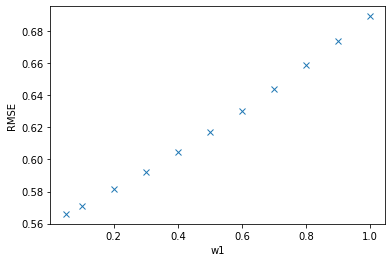

In [82]:
plt.plot(w1s,errors,'x')
plt.xlabel('w1')
plt.ylabel('RMSE')
plt.show()

In [83]:
best = w1s[errors.argmin()]
print('Best w1 on train set: ', best)

Best w1 on train set:  0.05


In [84]:
RMSE_train = errors.min()
print('RMSE on train set: ',RMSE_train)

RMSE on train set:  0.5660320087853132


In [85]:
w1 = best
w2 = 1 - best

Evaluacija na test skupu, sa $w_1 = 0.1, w_2 = 0.9$.

In [86]:
true_ratings_test = list(test_ratings['rating'])
sample_test = test_ratings.sample(50)
predictions_test = []

for row in sample_test.itertuples():
    u = row[1]
    i = row[3]
    pred = w1 * prediction(data_matrix,cos_sim1,u,i) + w2 * prediction(data_matrix,cos_sim2,u,i)
    predictions_test.append(pred)


In [88]:
RMSE_test = np.sqrt(mean_squared_error(true_ratings,predictions))
print('RMSE on test set',RMSE_test)

RMSE on test set 0.6893850293459488


## NOTE
* Vidi da li je drugacije trebalo deliti na trening i test skup
* Dalje se može implementirati funkcija **personalized_recommend(u,n)** koja radi sledeće:
    * na osnovu prosleđenog id-a korisnika, nalazi za sve filmove (kojih ima oko 9,000) predvidjenu ocenu, pomoću funkcije **prediction** i cuva u mapi film-predvidjena ocena
    * uzima n filmova sa najvećom predviđenom ocenom kao preporuku korisniku u